# Tarea: Juego de la Vida de Conway - Mundos Especiales

#### *Importación de bibliotecas*

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import convolve
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

---

### PARTE A: Implementación en diferentes mundos

#### *Funciones básicas del juego de la vida*

In [22]:
def actualiza_Pob(Pob):
    """
    Actualiza la población siguiendo las reglas del juego de la vida.
    
    Parámetros:
    -----------
    Pob : array 2D
        Población actual
    
    Retorna:
    --------
    nueva_Pob : array 2D
        Población en la siguiente generación
    """
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    num_vecinos = convolve2d(Pob, kernel, mode='same')
    nueva_Pob = np.where((Pob == 1) & ((num_vecinos == 2) | (num_vecinos == 3)), 1,
                         np.where((Pob == 0) & (num_vecinos == 3), 1, 0))
    return nueva_Pob

#### *Funciones para crear máscaras de diferentes mundos*

In [23]:
def mundo_cruz(N, ancho_brazo=None):
    """
    Crea una máscara en forma de cruz.
    
    Parámetros:
    -----------
    N : int
        Dimensión de la cuadrícula (NxN)
    ancho_brazo : int, opcional
        Ancho de los brazos de la cruz. Si es None, se usa N//3
    
    Retorna:
    --------
    mask_cruz : array 2D
        Máscara binaria con forma de cruz
    """
    if ancho_brazo is None:
        ancho_brazo = max(N // 3, 1)
    
    mask_cruz = np.zeros((N, N))
    centro = N // 2
    mitad_ancho = ancho_brazo // 2
    
    # Brazo vertical
    mask_cruz[:, centro - mitad_ancho:centro + mitad_ancho + 1] = 1
    
    # Brazo horizontal
    mask_cruz[centro - mitad_ancho:centro + mitad_ancho + 1, :] = 1
    
    return mask_cruz


def mundo_circunferencia(N, grosor=2):
    """
    Crea una máscara en forma de circunferencia (anillo).
    
    Parámetros:
    -----------
    N : int
        Dimensión de la cuadrícula (NxN)
    grosor : int
        Grosor del anillo
    
    Retorna:
    --------
    mask_circunferencia : array 2D
        Máscara binaria con forma de circunferencia
    """
    mask_circunferencia = np.zeros((N, N))
    centro = (N / 2, N / 2)
    radio_externo = N / 2
    radio_interno = radio_externo - grosor
    
    for i in range(N):
        for j in range(N):
            distancia = np.sqrt((i - centro[0] + 0.5)**2 + (j - centro[1] + 0.5)**2)
            if radio_interno <= distancia <= radio_externo:
                mask_circunferencia[i, j] = 1
    
    return mask_circunferencia


def mundo_circular(N):
    """
    Crea una máscara circular (disco lleno).
    
    Parámetros:
    -----------
    N : int
        Dimensión de la cuadrícula (NxN)
    
    Retorna:
    --------
    mask_circular : array 2D
        Máscara binaria con forma circular
    """
    mask_circular = np.zeros((N, N))
    centro = (N / 2, N / 2)
    
    for i in range(N):
        for j in range(N):
            distancia = np.sqrt((i - centro[0] + 0.5)**2 + (j - centro[1] + 0.5)**2)
            if distancia <= N / 2:
                mask_circular[i, j] = 1
    
    return mask_circular

#### *Visualización de las máscaras*

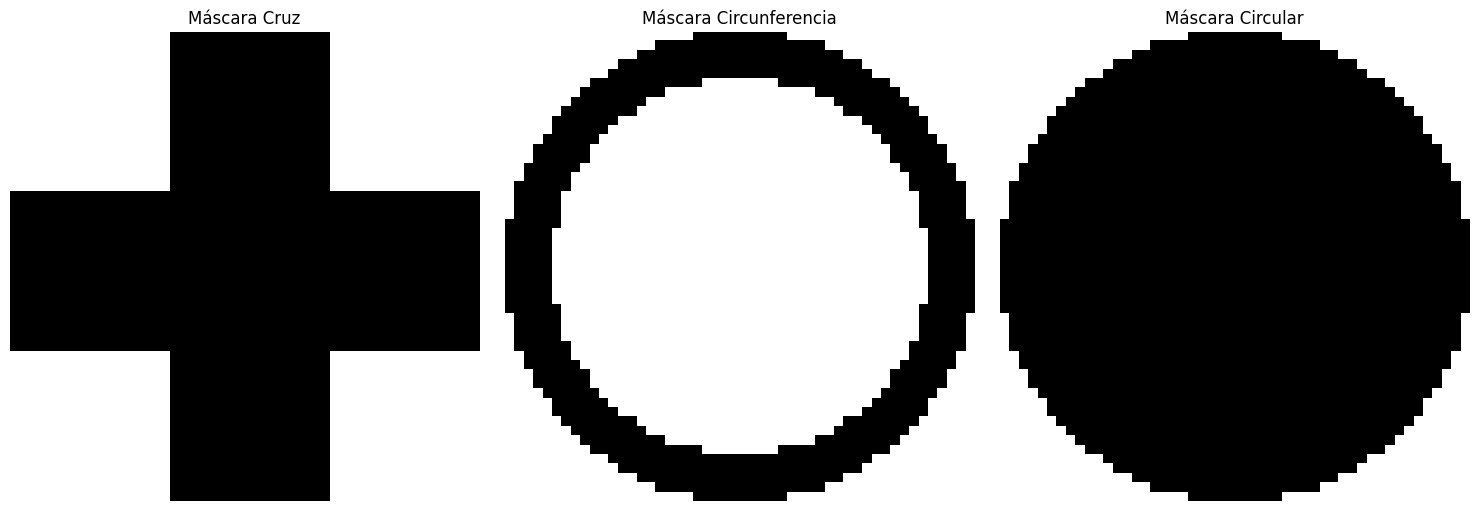

In [24]:
# Crear y visualizar las máscaras
N = 50
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

masks = [
    (mundo_cruz(N), 'Máscara Cruz'),
    (mundo_circunferencia(N, grosor=5), 'Máscara Circunferencia'),
    (mundo_circular(N), 'Máscara Circular')
]

for ax, (mask, titulo) in zip(axes, masks):
    ax.imshow(1 - mask, cmap='gray')
    ax.set_title(titulo)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### *Clase para el juego de la vida en 2D con diferentes formas*

In [25]:
class JuegoVida2D:
    """
    Implementa el juego de la vida de Conway en 2D con diferentes formas de mundo.
    """
    
    def __init__(self, N=50, prob_vida=0.3, n_iter=50, semilla=None, 
                 tipo_mundo='cuadrado', **kwargs):
        """
        Parámetros:
        -----------
        N : int
            Tamaño del mundo (NxN)
        prob_vida : float
            Probabilidad de que una célula esté viva inicialmente
        n_iter : int
            Número de iteraciones
        semilla : int, opcional
            Semilla para reproducibilidad
        tipo_mundo : str
            Tipo de mundo: 'cuadrado', 'cruz', 'circunferencia', 'circular'
        **kwargs : dict
            Parámetros adicionales según el tipo de mundo
        """
        self.N = N
        self.prob_vida = prob_vida
        self.n_iter = n_iter
        self.semilla = semilla
        self.tipo_mundo = tipo_mundo
        self.kwargs = kwargs
        
        # Crear la máscara según el tipo de mundo
        if tipo_mundo == 'cruz':
            self.mask = mundo_cruz(N, **kwargs)
        elif tipo_mundo == 'circunferencia':
            self.mask = mundo_circunferencia(N, **kwargs)
        elif tipo_mundo == 'circular':
            self.mask = mundo_circular(N)
        else:  # cuadrado
            self.mask = np.ones((N, N))
        
        self.Historia = None
    
    def Pob_ini(self):
        """Genera la población inicial."""
        if self.semilla is not None:
            np.random.seed(self.semilla)
        
        celulas = np.random.binomial(1, self.prob_vida, self.N * self.N).reshape(self.N, self.N)
        Pob = celulas * self.mask
        return Pob
    
    def evoluciona(self):
        """Evoluciona la población durante n_iter iteraciones."""
        self.Historia = np.zeros((self.n_iter, self.N, self.N))
        self.Historia[0, :, :] = self.Pob_ini()
        
        for i in range(1, self.n_iter):
            self.Historia[i, :, :] = actualiza_Pob(self.Historia[i-1, :, :]) * self.mask
        
        return self.Historia
    
    def visualizar_evolucion(self, frames_mostrar=6):
        """Visualiza la evolución de la población."""
        if self.Historia is None:
            self.evoluciona()
        
        indices = np.linspace(0, self.n_iter - 1, frames_mostrar, dtype=int)
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for idx, i in enumerate(indices):
            ax = axes[idx]
            ax.imshow(1 - self.Historia[i], cmap='gray')
            ax.set_title(f'Generación t = {i}')
            ax.axis('off')
        
        plt.suptitle(f'Evolución del Juego de la Vida - Mundo: {self.tipo_mundo.capitalize()}', 
                     fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    def crear_animacion(self):
        """Crea una animación de la evolución."""
        if self.Historia is None:
            self.evoluciona()
        
        fig, ax = plt.subplots(figsize=(8, 8))
        imagen = ax.imshow(1 - self.Historia[0], cmap='gray')
        titulo = ax.set_title(f'Población t = 0 - Mundo: {self.tipo_mundo.capitalize()}')
        ax.axis('off')
        
        def update(frame):
            imagen.set_data(1 - self.Historia[frame])
            titulo.set_text(f'Población t = {frame} - Mundo: {self.tipo_mundo.capitalize()}')
            return [imagen, titulo]
        
        ani = FuncAnimation(fig, update, frames=self.n_iter, interval=200, blit=True)
        plt.close()
        return HTML(ani.to_jshtml())

#### *Ejemplos de uso para cada tipo de mundo*

=== MUNDO EN FORMA DE CRUZ ===


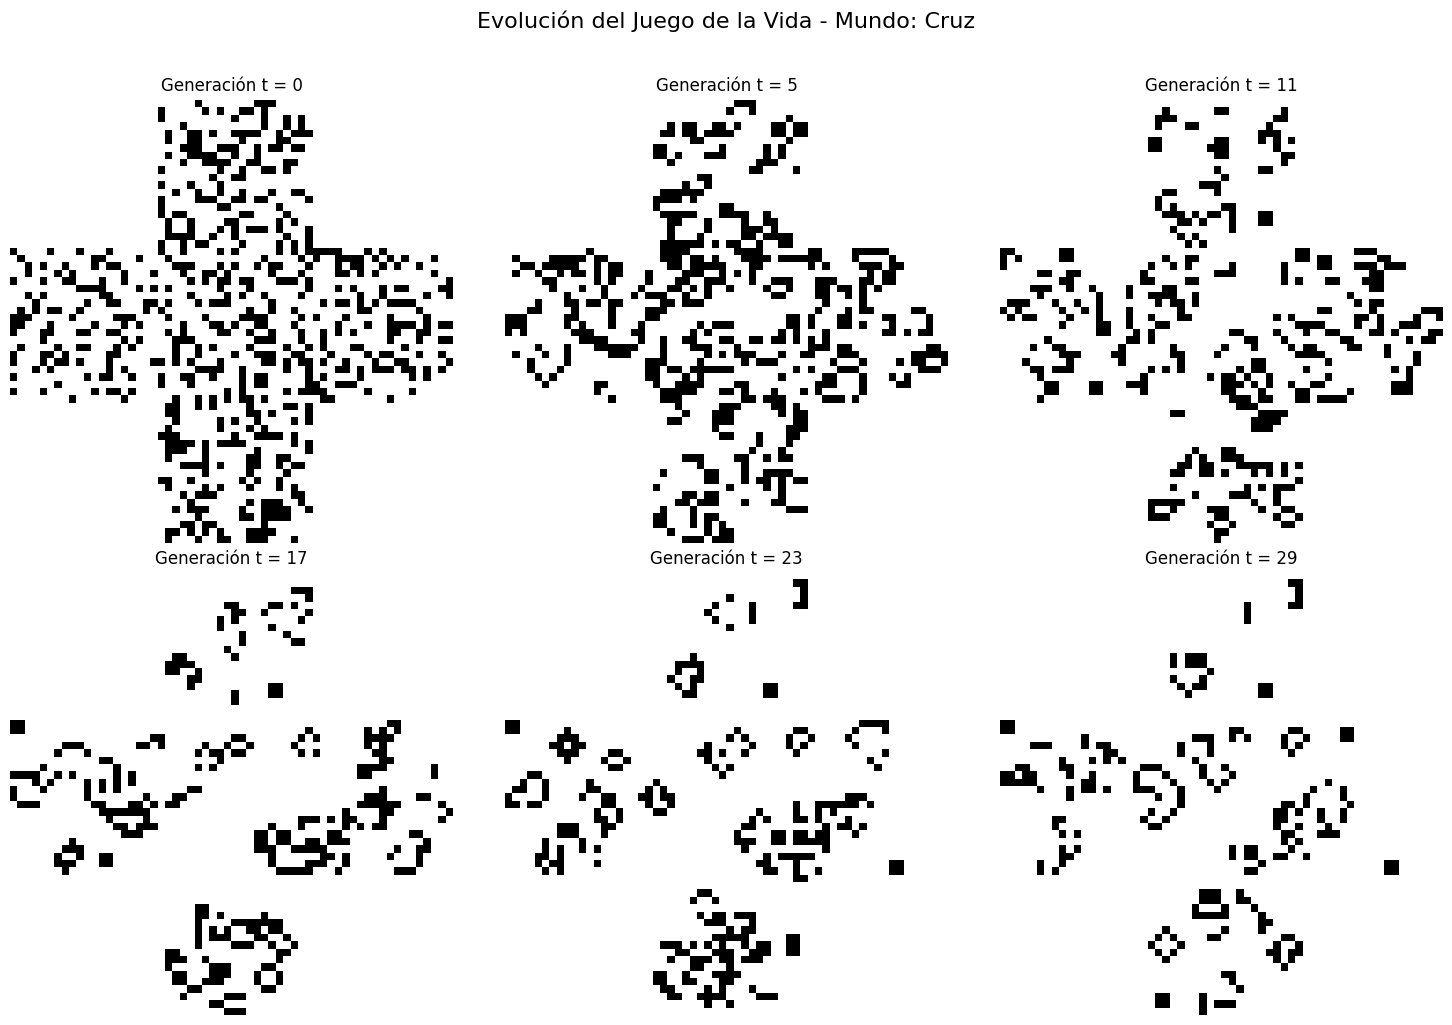

In [26]:
# Mundo en forma de Cruz
print("=== MUNDO EN FORMA DE CRUZ ===")
juego_cruz = JuegoVida2D(N=60, prob_vida=0.3, n_iter=30, semilla=42, 
                         tipo_mundo='cruz', ancho_brazo=20)
juego_cruz.visualizar_evolucion()

=== MUNDO EN FORMA DE CIRCUNFERENCIA ===


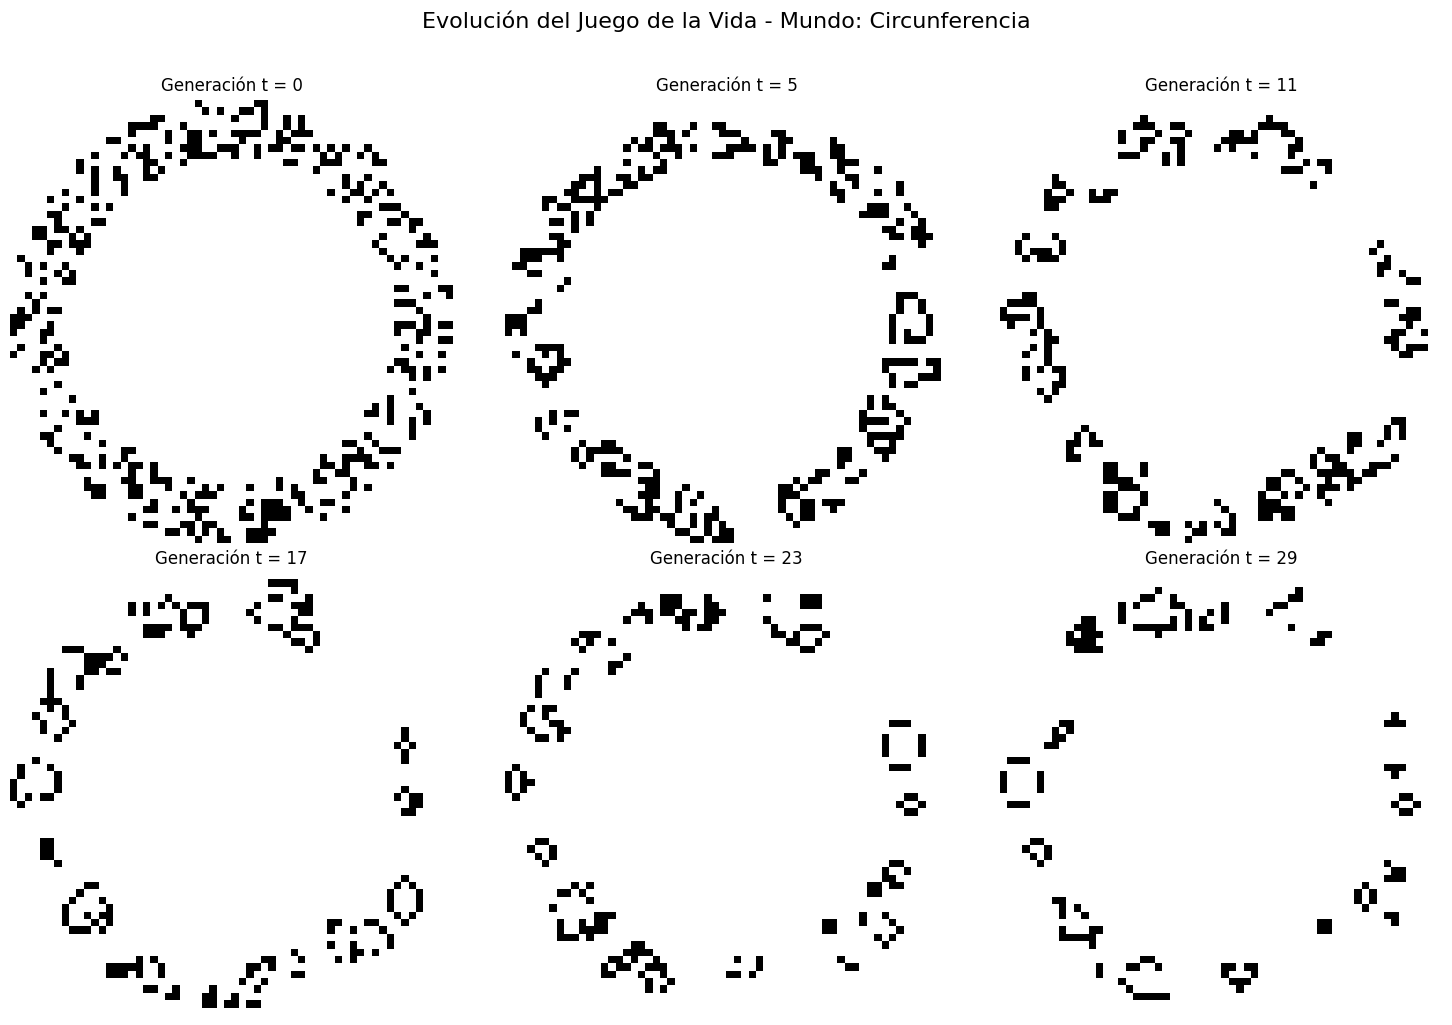

In [27]:
# Mundo en forma de Circunferencia
print("=== MUNDO EN FORMA DE CIRCUNFERENCIA ===")
juego_circunferencia = JuegoVida2D(N=60, prob_vida=0.3, n_iter=30, semilla=42,
                                    tipo_mundo='circunferencia', grosor=8)
juego_circunferencia.visualizar_evolucion()

=== MUNDO CIRCULAR ===


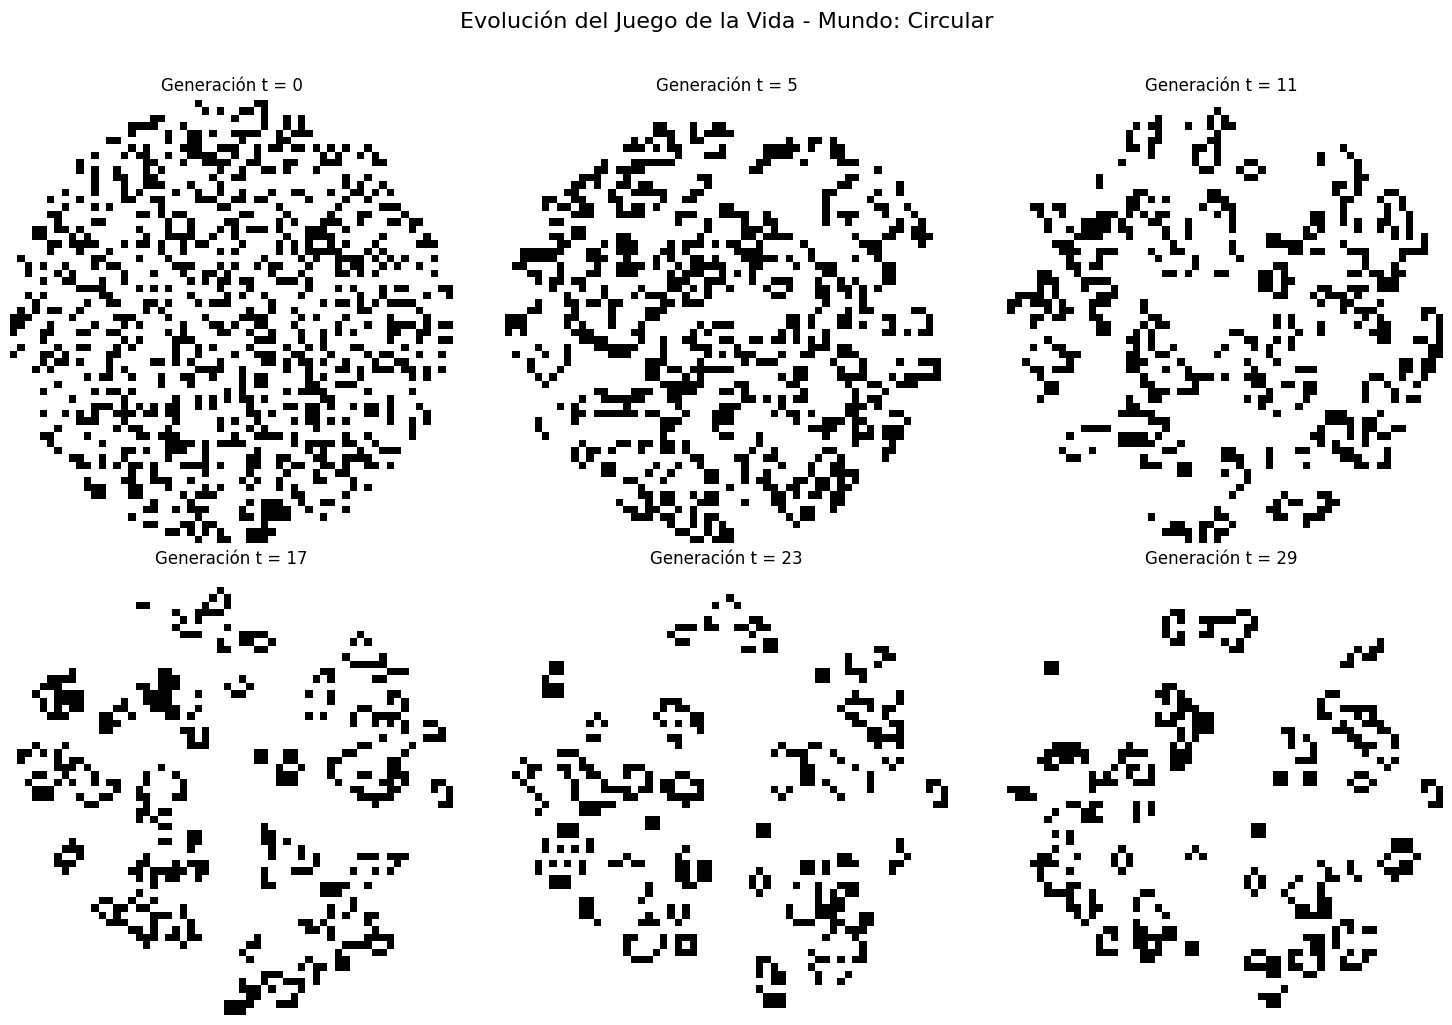

In [28]:
# Mundo Circular (para comparación)
print("=== MUNDO CIRCULAR ===")
juego_circular = JuegoVida2D(N=60, prob_vida=0.3, n_iter=30, semilla=42,
                              tipo_mundo='circular')
juego_circular.visualizar_evolucion()

#### *Juego de la Vida en 3D (Cubo)*

Para el mundo en forma de cubo, extendemos el juego a tres dimensiones. En este caso, cada célula tiene hasta 26 vecinos (3³ - 1).

In [29]:
def actualiza_Pob_3D(Pob):
    """
    Actualiza la población en 3D siguiendo las reglas del juego de la vida.
    
    Parámetros:
    -----------
    Pob : array 3D
        Población actual
    
    Retorna:
    --------
    nueva_Pob : array 3D
        Población en la siguiente generación
    """
    # Kernel 3D: cuenta los 26 vecinos
    kernel = np.ones((3, 3, 3))
    kernel[1, 1, 1] = 0  # No contar la célula central
    
    num_vecinos = convolve(Pob, kernel, mode='constant', cval=0)
    
    # Reglas del juego de la vida en 3D (adaptadas)
    # Vive: si tiene 4, 5 o 6 vecinos
    # Nace: si tiene 5 vecinos
    nueva_Pob = np.where((Pob == 1) & ((num_vecinos >= 4) & (num_vecinos <= 6)), 1,
                         np.where((Pob == 0) & (num_vecinos == 5), 1, 0))
    
    return nueva_Pob

In [30]:
class JuegoVida3D:
    """
    Implementa el juego de la vida de Conway en 3D (cubo).
    """
    
    def __init__(self, N=20, prob_vida=0.3, n_iter=20, semilla=None):
        """
        Parámetros:
        -----------
        N : int
            Tamaño del cubo (NxNxN)
        prob_vida : float
            Probabilidad de que una célula esté viva inicialmente
        n_iter : int
            Número de iteraciones
        semilla : int, opcional
            Semilla para reproducibilidad
        """
        self.N = N
        self.prob_vida = prob_vida
        self.n_iter = n_iter
        self.semilla = semilla
        self.Historia = None
    
    def Pob_ini(self):
        """Genera la población inicial en 3D."""
        if self.semilla is not None:
            np.random.seed(self.semilla)
        
        celulas = np.random.binomial(1, self.prob_vida, self.N**3).reshape(self.N, self.N, self.N)
        return celulas
    
    def evoluciona(self):
        """Evoluciona la población durante n_iter iteraciones."""
        self.Historia = np.zeros((self.n_iter, self.N, self.N, self.N))
        self.Historia[0, :, :, :] = self.Pob_ini()
        
        for i in range(1, self.n_iter):
            self.Historia[i, :, :, :] = actualiza_Pob_3D(self.Historia[i-1, :, :, :])
        
        return self.Historia
    
    def visualizar_evolucion(self, frames_mostrar=4):
        """
        Visualiza la evolución mostrando cortes transversales del cubo.
        """
        if self.Historia is None:
            self.evoluciona()
        
        indices = np.linspace(0, self.n_iter - 1, frames_mostrar, dtype=int)
        
        fig, axes = plt.subplots(frames_mostrar, 3, figsize=(12, 4*frames_mostrar))
        
        for idx, i in enumerate(indices):
            # Corte en el plano medio de cada dimensión
            mid = self.N // 2
            
            # Corte XY (z = mid)
            axes[idx, 0].imshow(1 - self.Historia[i, :, :, mid], cmap='gray')
            axes[idx, 0].set_title(f't={i}, Plano XY (z={mid})')
            axes[idx, 0].axis('off')
            
            # Corte XZ (y = mid)
            axes[idx, 1].imshow(1 - self.Historia[i, :, mid, :], cmap='gray')
            axes[idx, 1].set_title(f't={i}, Plano XZ (y={mid})')
            axes[idx, 1].axis('off')
            
            # Corte YZ (x = mid)
            axes[idx, 2].imshow(1 - self.Historia[i, mid, :, :], cmap='gray')
            axes[idx, 2].set_title(f't={i}, Plano YZ (x={mid})')
            axes[idx, 2].axis('off')
        
        plt.suptitle('Evolución del Juego de la Vida 3D - Cortes Transversales', 
                     fontsize=16, y=1.0)
        plt.tight_layout()
        plt.show()
    
    def visualizar_3d(self, tiempo=0, umbral_densidad=0.5):
        """
        Visualiza el cubo en 3D mostrando solo células vivas.
        
        Parámetros:
        -----------
        tiempo : int
            Índice de tiempo a visualizar
        umbral_densidad : float
            Si la densidad de células vivas es mayor que este umbral,
            se muestra una muestra aleatoria para mejorar la visualización
        """
        if self.Historia is None:
            self.evoluciona()
        
        Pob = self.Historia[tiempo]
        
        # Encontrar posiciones de células vivas
        x, y, z = np.where(Pob == 1)
        
        # Si hay demasiadas células, mostrar solo una muestra
        densidad = len(x) / (self.N**3)
        if densidad > umbral_densidad:
            n_muestras = int(self.N**3 * umbral_densidad)
            indices = np.random.choice(len(x), n_muestras, replace=False)
            x, y, z = x[indices], y[indices], z[indices]
            titulo_extra = f" (muestra del {umbral_densidad*100:.0f}%)"
        else:
            titulo_extra = ""
        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        ax.scatter(x, y, z, c='black', marker='s', s=20, alpha=0.6)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(f'Juego de la Vida 3D - t={tiempo}{titulo_extra}')
        
        ax.set_xlim([0, self.N])
        ax.set_ylim([0, self.N])
        ax.set_zlim([0, self.N])
        
        plt.show()

#### *Ejemplo de uso del juego de la vida en 3D*

=== JUEGO DE LA VIDA 3D (CUBO) ===


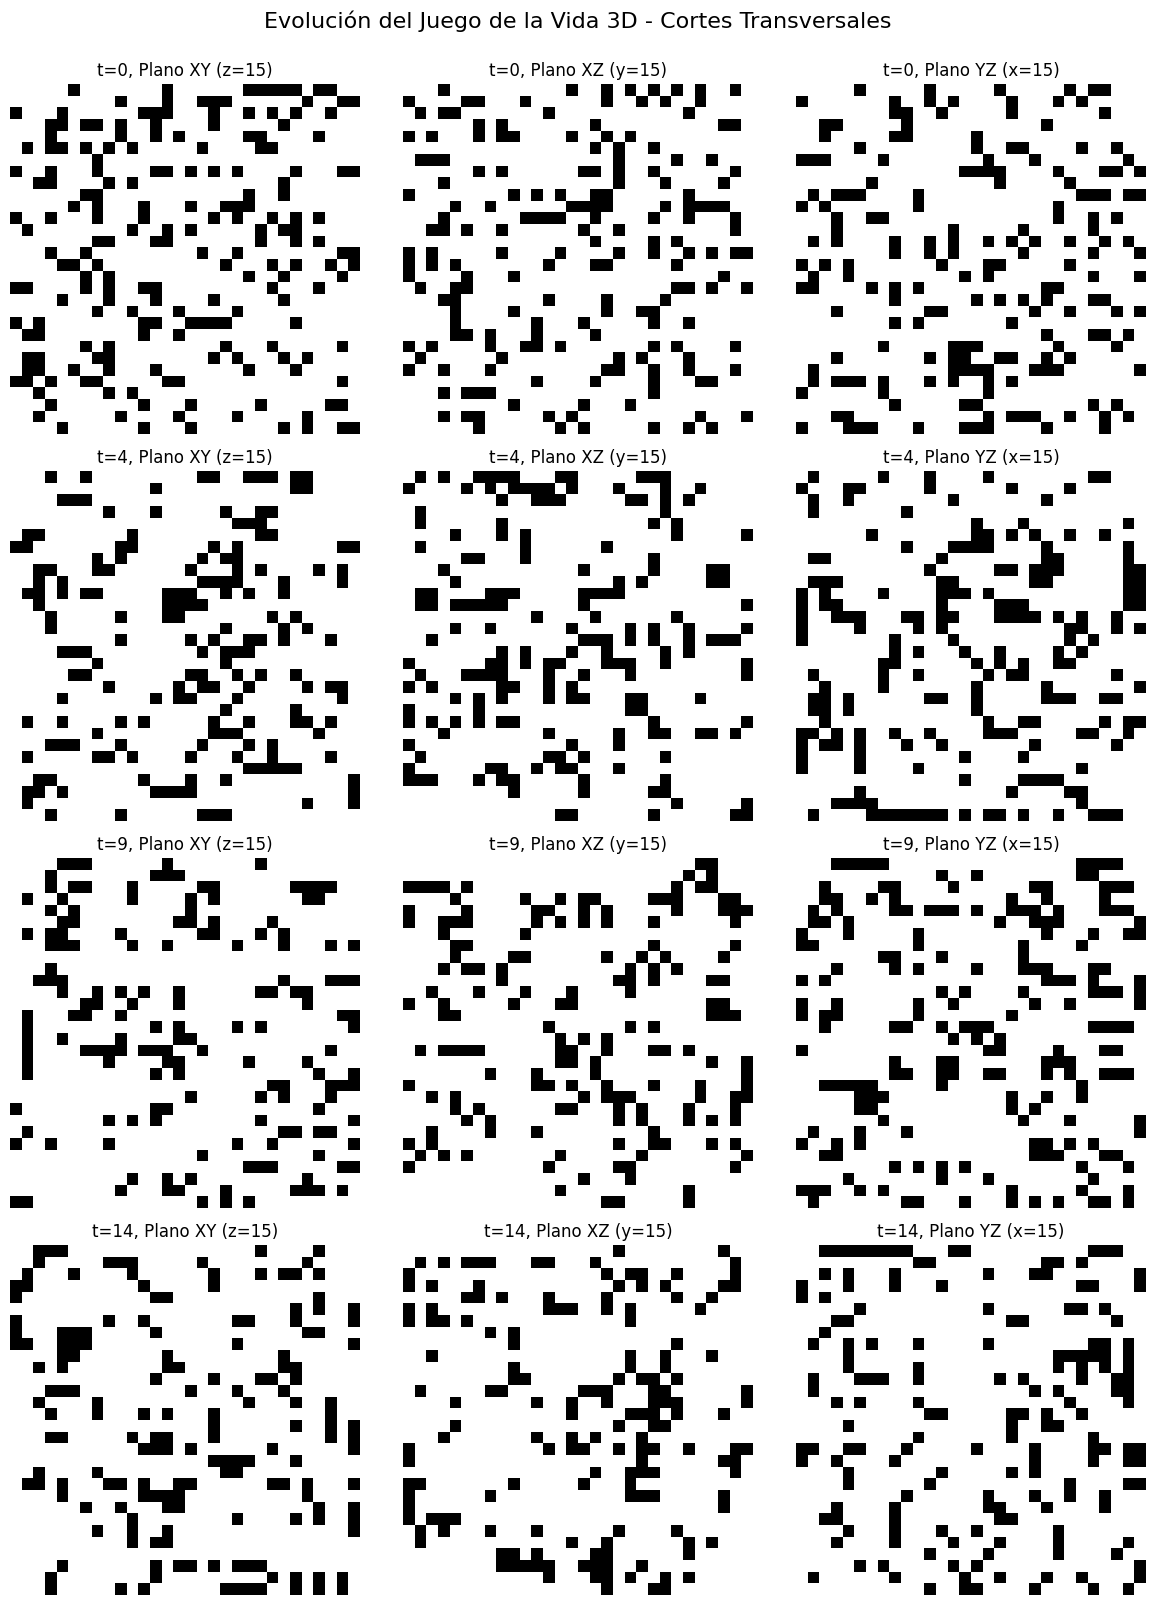

In [31]:
# Crear juego en 3D
print("=== JUEGO DE LA VIDA 3D (CUBO) ===")
juego_3d = JuegoVida3D(N=30, prob_vida=0.2, n_iter=15, semilla=42)
juego_3d.evoluciona()

# Visualizar cortes transversales
juego_3d.visualizar_evolucion(frames_mostrar=4)

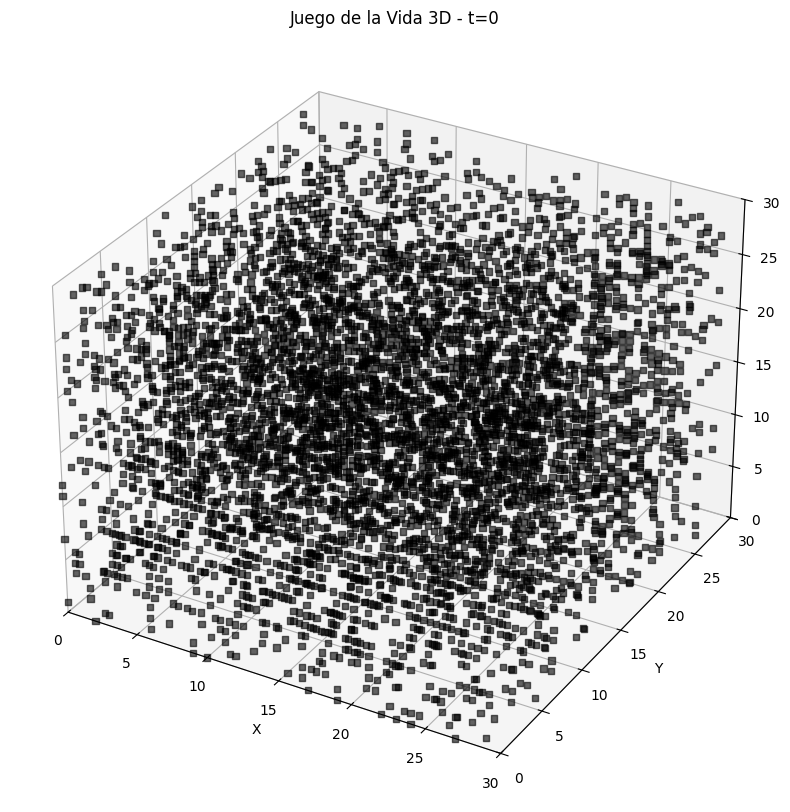

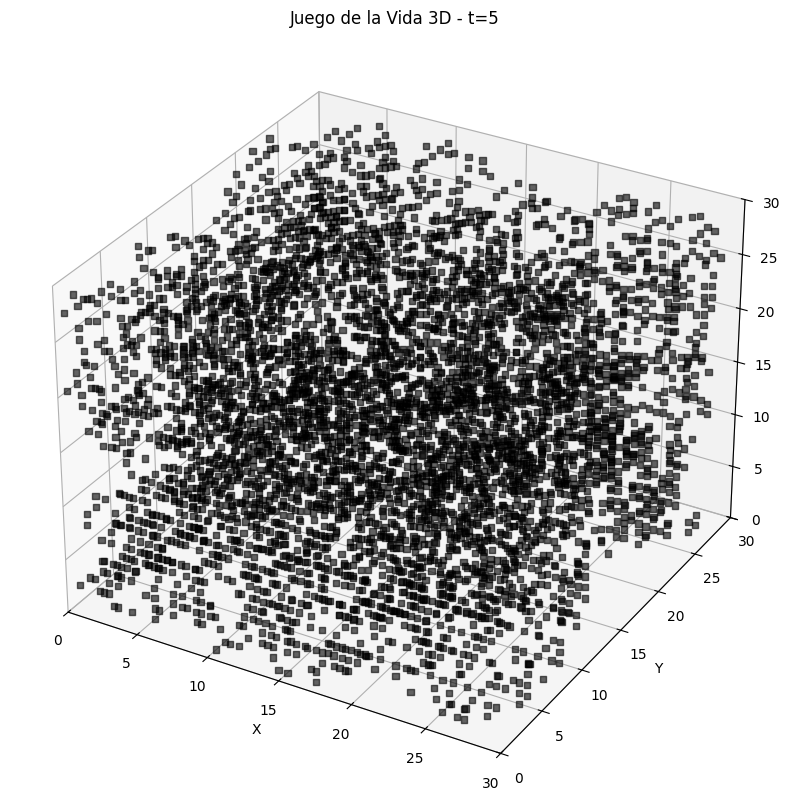

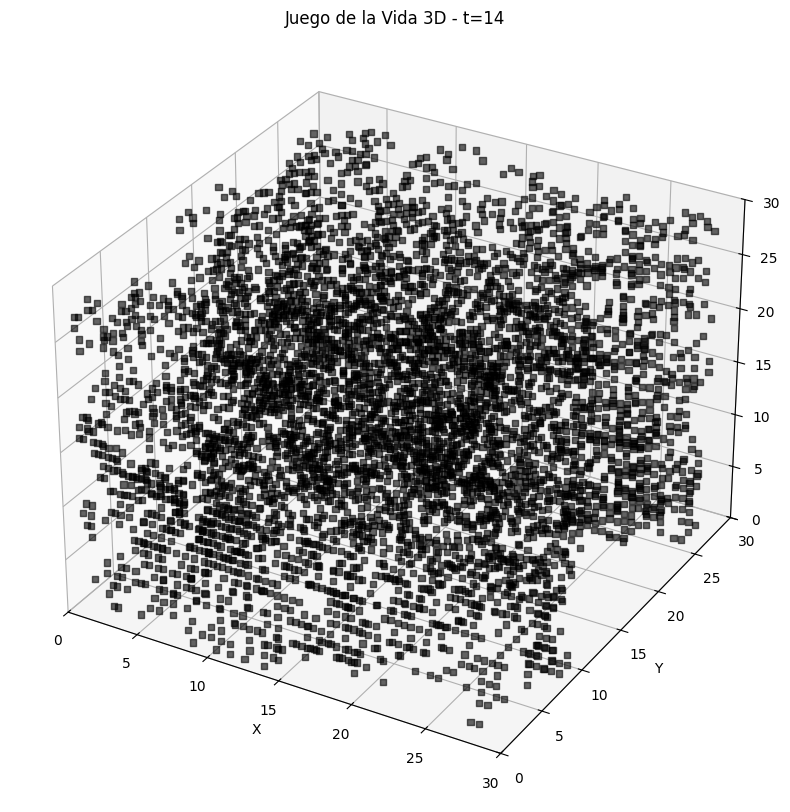

In [32]:
# Visualización 3D de diferentes momentos
juego_3d.visualizar_3d(tiempo=0, umbral_densidad=0.3)
juego_3d.visualizar_3d(tiempo=5, umbral_densidad=0.3)
juego_3d.visualizar_3d(tiempo=14, umbral_densidad=0.3)

---
# PARTE B: Estudio del efecto del parámetro p

Vamos a estudiar cómo el parámetro $p$ (probabilidad inicial de vida) afecta:
1. La tasa de células vivas con 2 o 3 vecinos vivos en la generación inicial
2. La tasa de células muertas con exactamente 3 vecinos vivos en la generación inicial

## 1. Funciones para calcular estadísticas

In [33]:
def calcular_estadisticas_2D(Pob, mask=None):
    """
    Calcula estadísticas sobre la población inicial en 2D.
    
    Parámetros:
    -----------
    Pob : array 2D
        Población inicial
    mask : array 2D, opcional
        Máscara del mundo
    
    Retorna:
    --------
    tasa_vivas_2_3_vecinos : float
        Tasa de células vivas con 2 o 3 vecinos vivos
    tasa_muertas_3_vecinos : float
        Tasa de células muertas con exactamente 3 vecinos vivos
    """
    # Calcular número de vecinos
    kernel = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
    num_vecinos = convolve2d(Pob, kernel, mode='same')
    
    if mask is not None:
        # Aplicar máscara
        celulas_validas = mask == 1
    else:
        celulas_validas = np.ones_like(Pob, dtype=bool)
    
    # Total de células válidas
    total_celulas = celulas_validas.sum()
    
    # a) Células vivas con 2 o 3 vecinos vivos
    vivas_2_3 = ((Pob == 1) & ((num_vecinos == 2) | (num_vecinos == 3)) & celulas_validas).sum()
    tasa_vivas_2_3_vecinos = vivas_2_3 / total_celulas
    
    # b) Células muertas con exactamente 3 vecinos vivos
    muertas_3 = ((Pob == 0) & (num_vecinos == 3) & celulas_validas).sum()
    tasa_muertas_3_vecinos = muertas_3 / total_celulas
    
    return tasa_vivas_2_3_vecinos, tasa_muertas_3_vecinos


def calcular_estadisticas_3D(Pob):
    """
    Calcula estadísticas sobre la población inicial en 3D.
    
    Parámetros:
    -----------
    Pob : array 3D
        Población inicial
    
    Retorna:
    --------
    tasa_vivas_4_5_6_vecinos : float
        Tasa de células vivas con 4, 5 o 6 vecinos vivos
    tasa_muertas_5_vecinos : float
        Tasa de células muertas con exactamente 5 vecinos vivos
    """
    # Calcular número de vecinos en 3D
    kernel = np.ones((3, 3, 3))
    kernel[1, 1, 1] = 0
    num_vecinos = convolve(Pob, kernel, mode='constant', cval=0)
    
    total_celulas = Pob.size
    
    # a) Células vivas con 4, 5 o 6 vecinos (condiciones para sobrevivir en 3D)
    vivas_4_5_6 = ((Pob == 1) & ((num_vecinos >= 4) & (num_vecinos <= 6))).sum()
    tasa_vivas_4_5_6_vecinos = vivas_4_5_6 / total_celulas
    
    # b) Células muertas con exactamente 5 vecinos (condición para nacer en 3D)
    muertas_5 = ((Pob == 0) & (num_vecinos == 5)).sum()
    tasa_muertas_5_vecinos = muertas_5 / total_celulas
    
    return tasa_vivas_4_5_6_vecinos, tasa_muertas_5_vecinos

## 2. Simulación para cuadrícula NxN

In [34]:
def simular_efecto_p_2D(N=40, probs=None, num_simulaciones=500):
    """
    Simula el efecto de p en una cuadrícula NxN.
    
    Parámetros:
    -----------
    N : int
        Tamaño de la cuadrícula
    probs : array, opcional
        Valores de p a simular
    num_simulaciones : int
        Número de simulaciones por cada valor de p
    
    Retorna:
    --------
    resultados : dict
        Diccionario con los resultados de las simulaciones
    """
    if probs is None:
        probs = np.arange(0.01, 1.0, 0.02)
    
    resultados = {
        'probs': probs,
        'tasa_vivas_2_3': np.zeros((len(probs), num_simulaciones)),
        'tasa_muertas_3': np.zeros((len(probs), num_simulaciones))
    }
    
    print(f"Simulando para cuadrícula {N}x{N}...")
    
    for i, p in enumerate(probs):
        if i % 10 == 0:
            print(f"  Progreso: {i}/{len(probs)} valores de p completados")
        
        for j in range(num_simulaciones):
            # Generar población inicial
            Pob = np.random.binomial(1, p, N*N).reshape(N, N)
            
            # Calcular estadísticas
            tasa_vivas, tasa_muertas = calcular_estadisticas_2D(Pob)
            
            resultados['tasa_vivas_2_3'][i, j] = tasa_vivas
            resultados['tasa_muertas_3'][i, j] = tasa_muertas
    
    print("  Simulación completada!")
    return resultados

In [35]:
# Ejecutar simulación para 2D
np.random.seed(2026)
N_2D = 40
resultados_2D = simular_efecto_p_2D(N=N_2D, num_simulaciones=500)

# Calcular estadísticas
media_vivas_2_3 = np.mean(resultados_2D['tasa_vivas_2_3'], axis=1)
std_vivas_2_3 = np.std(resultados_2D['tasa_vivas_2_3'], axis=1)

media_muertas_3 = np.mean(resultados_2D['tasa_muertas_3'], axis=1)
std_muertas_3 = np.std(resultados_2D['tasa_muertas_3'], axis=1)

Simulando para cuadrícula 40x40...
  Progreso: 0/50 valores de p completados
  Progreso: 10/50 valores de p completados
  Progreso: 20/50 valores de p completados
  Progreso: 30/50 valores de p completados
  Progreso: 40/50 valores de p completados
  Simulación completada!


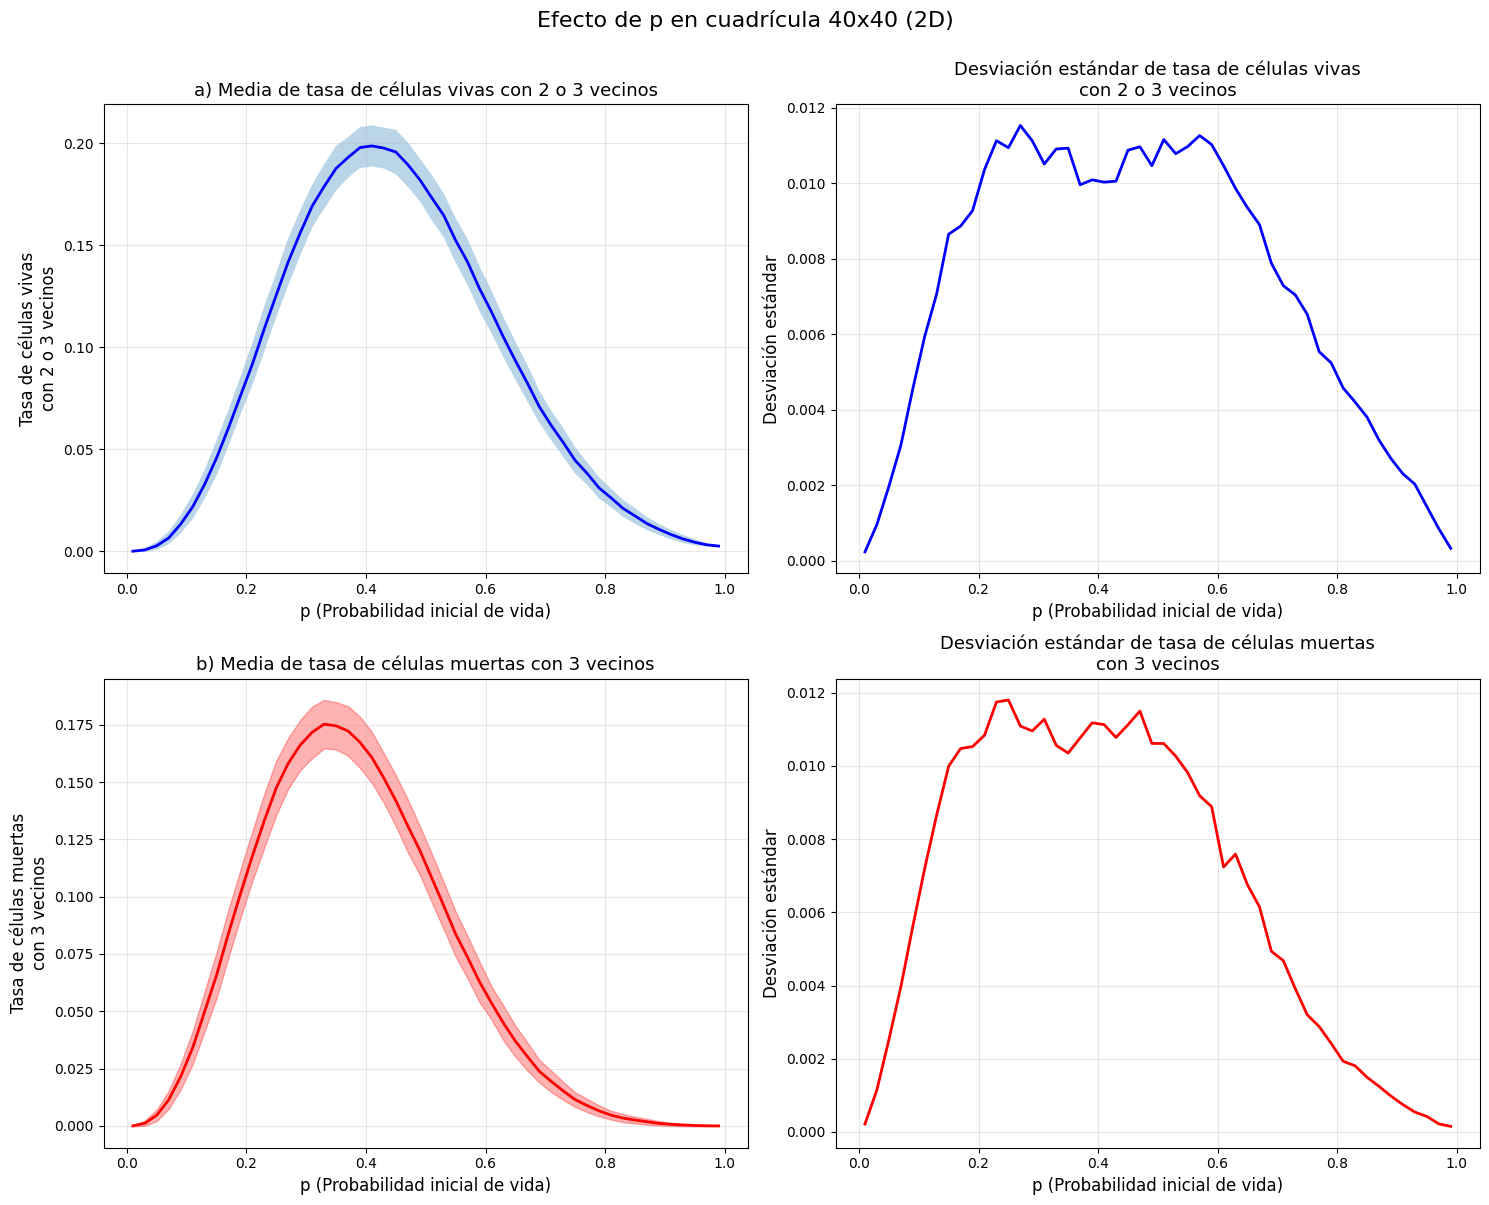

In [36]:
# Visualizar resultados 2D
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Tasa de células vivas con 2 o 3 vecinos - Media
axes[0, 0].plot(resultados_2D['probs'], media_vivas_2_3, 'b-', linewidth=2)
axes[0, 0].fill_between(resultados_2D['probs'], 
                         media_vivas_2_3 - std_vivas_2_3,
                         media_vivas_2_3 + std_vivas_2_3,
                         alpha=0.3)
axes[0, 0].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[0, 0].set_ylabel('Tasa de células vivas\ncon 2 o 3 vecinos', fontsize=12)
axes[0, 0].set_title('a) Media de tasa de células vivas con 2 o 3 vecinos', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)

# Tasa de células vivas con 2 o 3 vecinos - Desviación estándar
axes[0, 1].plot(resultados_2D['probs'], std_vivas_2_3, 'b-', linewidth=2)
axes[0, 1].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[0, 1].set_ylabel('Desviación estándar', fontsize=12)
axes[0, 1].set_title('Desviación estándar de tasa de células vivas\ncon 2 o 3 vecinos', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Tasa de células muertas con 3 vecinos - Media
axes[1, 0].plot(resultados_2D['probs'], media_muertas_3, 'r-', linewidth=2)
axes[1, 0].fill_between(resultados_2D['probs'],
                         media_muertas_3 - std_muertas_3,
                         media_muertas_3 + std_muertas_3,
                         alpha=0.3, color='red')
axes[1, 0].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[1, 0].set_ylabel('Tasa de células muertas\ncon 3 vecinos', fontsize=12)
axes[1, 0].set_title('b) Media de tasa de células muertas con 3 vecinos', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# Tasa de células muertas con 3 vecinos - Desviación estándar
axes[1, 1].plot(resultados_2D['probs'], std_muertas_3, 'r-', linewidth=2)
axes[1, 1].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[1, 1].set_ylabel('Desviación estándar', fontsize=12)
axes[1, 1].set_title('Desviación estándar de tasa de células muertas\ncon 3 vecinos', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Efecto de p en cuadrícula {N_2D}x{N_2D} (2D)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 3. Simulación para cubo NxNxN

In [37]:
def simular_efecto_p_3D(N=30, probs=None, num_simulaciones=200):
    """
    Simula el efecto de p en un cubo NxNxN.
    
    Parámetros:
    -----------
    N : int
        Tamaño del cubo
    probs : array, opcional
        Valores de p a simular
    num_simulaciones : int
        Número de simulaciones por cada valor de p
    
    Retorna:
    --------
    resultados : dict
        Diccionario con los resultados de las simulaciones
    """
    if probs is None:
        probs = np.arange(0.01, 1.0, 0.02)
    
    resultados = {
        'probs': probs,
        'tasa_vivas_4_5_6': np.zeros((len(probs), num_simulaciones)),
        'tasa_muertas_5': np.zeros((len(probs), num_simulaciones))
    }
    
    print(f"Simulando para cubo {N}x{N}x{N}...")
    print("NOTA: Esta simulación puede tardar varios minutos debido al tamaño del espacio 3D")
    
    for i, p in enumerate(probs):
        if i % 5 == 0:
            print(f"  Progreso: {i}/{len(probs)} valores de p completados")
        
        for j in range(num_simulaciones):
            # Generar población inicial
            Pob = np.random.binomial(1, p, N**3).reshape(N, N, N)
            
            # Calcular estadísticas
            tasa_vivas, tasa_muertas = calcular_estadisticas_3D(Pob)
            
            resultados['tasa_vivas_4_5_6'][i, j] = tasa_vivas
            resultados['tasa_muertas_5'][i, j] = tasa_muertas
    
    print("  Simulación completada!")
    return resultados

In [38]:
# Ejecutar simulación para 3D (puede tardar varios minutos)
np.random.seed(2026)
N_3D = 32  # Tamaño razonable para simulación
resultados_3D = simular_efecto_p_3D(N=N_3D, num_simulaciones=200)

# Calcular estadísticas
media_vivas_4_5_6 = np.mean(resultados_3D['tasa_vivas_4_5_6'], axis=1)
std_vivas_4_5_6 = np.std(resultados_3D['tasa_vivas_4_5_6'], axis=1)

media_muertas_5 = np.mean(resultados_3D['tasa_muertas_5'], axis=1)
std_muertas_5 = np.std(resultados_3D['tasa_muertas_5'], axis=1)

Simulando para cubo 32x32x32...
NOTA: Esta simulación puede tardar varios minutos debido al tamaño del espacio 3D
  Progreso: 0/50 valores de p completados
  Progreso: 5/50 valores de p completados
  Progreso: 10/50 valores de p completados
  Progreso: 15/50 valores de p completados
  Progreso: 20/50 valores de p completados
  Progreso: 25/50 valores de p completados
  Progreso: 30/50 valores de p completados
  Progreso: 35/50 valores de p completados
  Progreso: 40/50 valores de p completados
  Progreso: 45/50 valores de p completados
  Simulación completada!


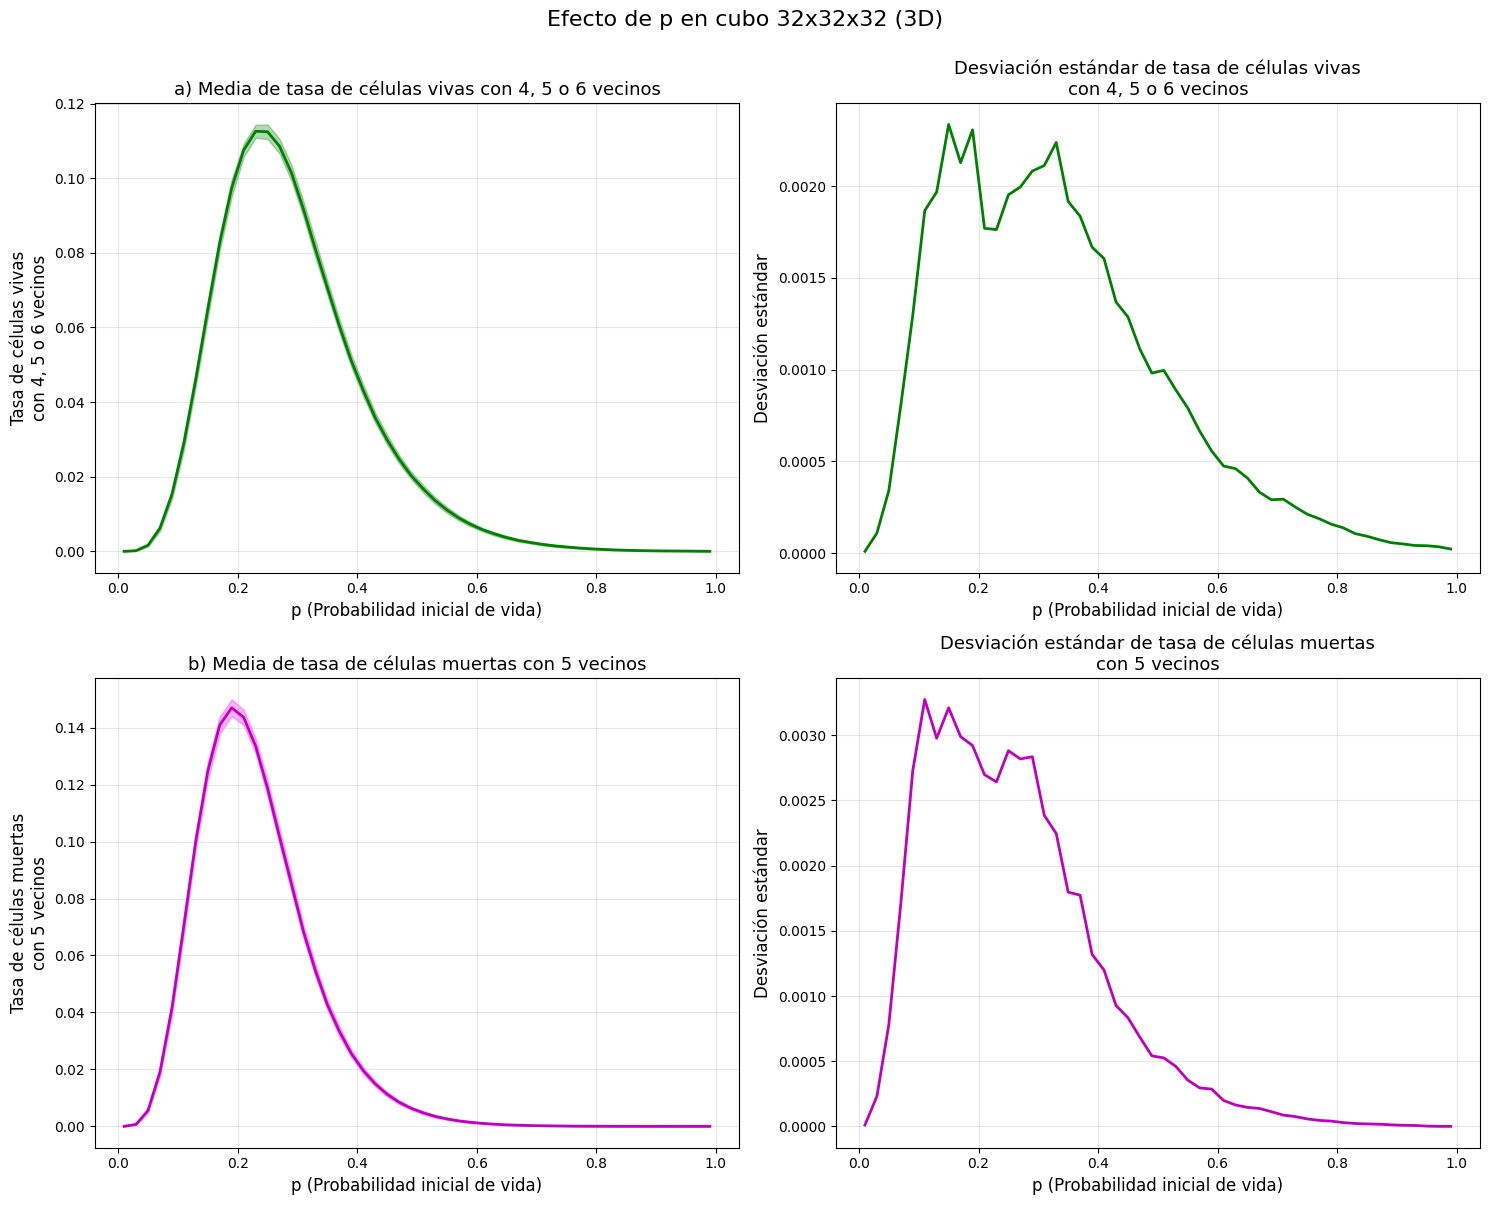

In [39]:
# Visualizar resultados 3D
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Tasa de células vivas con 4, 5 o 6 vecinos - Media
axes[0, 0].plot(resultados_3D['probs'], media_vivas_4_5_6, 'g-', linewidth=2)
axes[0, 0].fill_between(resultados_3D['probs'],
                         media_vivas_4_5_6 - std_vivas_4_5_6,
                         media_vivas_4_5_6 + std_vivas_4_5_6,
                         alpha=0.3, color='green')
axes[0, 0].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[0, 0].set_ylabel('Tasa de células vivas\ncon 4, 5 o 6 vecinos', fontsize=12)
axes[0, 0].set_title('a) Media de tasa de células vivas con 4, 5 o 6 vecinos', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)

# Tasa de células vivas con 4, 5 o 6 vecinos - Desviación estándar
axes[0, 1].plot(resultados_3D['probs'], std_vivas_4_5_6, 'g-', linewidth=2)
axes[0, 1].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[0, 1].set_ylabel('Desviación estándar', fontsize=12)
axes[0, 1].set_title('Desviación estándar de tasa de células vivas\ncon 4, 5 o 6 vecinos', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# Tasa de células muertas con 5 vecinos - Media
axes[1, 0].plot(resultados_3D['probs'], media_muertas_5, 'm-', linewidth=2)
axes[1, 0].fill_between(resultados_3D['probs'],
                         media_muertas_5 - std_muertas_5,
                         media_muertas_5 + std_muertas_5,
                         alpha=0.3, color='magenta')
axes[1, 0].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[1, 0].set_ylabel('Tasa de células muertas\ncon 5 vecinos', fontsize=12)
axes[1, 0].set_title('b) Media de tasa de células muertas con 5 vecinos', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# Tasa de células muertas con 5 vecinos - Desviación estándar
axes[1, 1].plot(resultados_3D['probs'], std_muertas_5, 'm-', linewidth=2)
axes[1, 1].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[1, 1].set_ylabel('Desviación estándar', fontsize=12)
axes[1, 1].set_title('Desviación estándar de tasa de células muertas\ncon 5 vecinos', fontsize=13)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Efecto de p en cubo {N_3D}x{N_3D}x{N_3D} (3D)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 4. Comparación 2D vs 3D

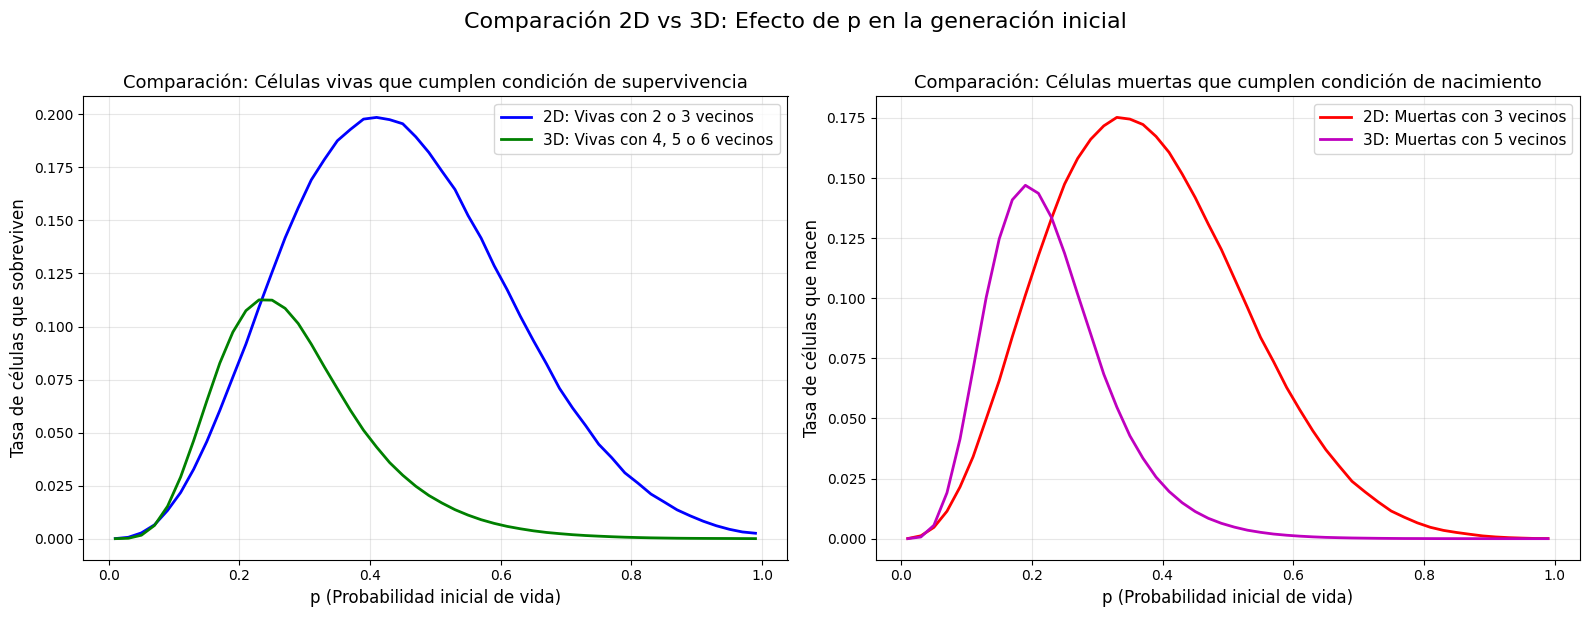

In [40]:
# Gráfico comparativo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Comparación de células vivas que sobreviven
axes[0].plot(resultados_2D['probs'], media_vivas_2_3, 'b-', linewidth=2, label='2D: Vivas con 2 o 3 vecinos')
axes[0].plot(resultados_3D['probs'], media_vivas_4_5_6, 'g-', linewidth=2, label='3D: Vivas con 4, 5 o 6 vecinos')
axes[0].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[0].set_ylabel('Tasa de células que sobreviven', fontsize=12)
axes[0].set_title('Comparación: Células vivas que cumplen condición de supervivencia', fontsize=13)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Comparación de células muertas que nacen
axes[1].plot(resultados_2D['probs'], media_muertas_3, 'r-', linewidth=2, label='2D: Muertas con 3 vecinos')
axes[1].plot(resultados_3D['probs'], media_muertas_5, 'm-', linewidth=2, label='3D: Muertas con 5 vecinos')
axes[1].set_xlabel('p (Probabilidad inicial de vida)', fontsize=12)
axes[1].set_ylabel('Tasa de células que nacen', fontsize=12)
axes[1].set_title('Comparación: Células muertas que cumplen condición de nacimiento', fontsize=13)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Comparación 2D vs 3D: Efecto de p en la generación inicial', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 5. Análisis e interpretación de resultados

### Observaciones clave:

#### Para el caso 2D (cuadrícula NxN):

1. **Células vivas con 2 o 3 vecinos (gráfico a):**
   - Esta curva muestra cómo varía la proporción de células vivas que tienen la condición ideal para sobrevivir
   - El máximo se alcanza para valores intermedios de p (típicamente alrededor de p=0.3-0.5)
   - Para p muy bajo o muy alto, pocas células tienen exactamente 2 o 3 vecinos

2. **Células muertas con 3 vecinos (gráfico b):**
   - Esta curva indica las células que pueden "nacer" en la siguiente generación
   - También presenta un máximo en valores intermedios de p
   - El comportamiento es similar al caso anterior pero con valores más bajos

#### Para el caso 3D (cubo NxNxN):

1. **Células vivas con 4, 5 o 6 vecinos:**
   - En 3D, cada célula tiene hasta 26 vecinos posibles (vs 8 en 2D)
   - Las condiciones de supervivencia se adaptan al mayor número de vecinos
   - El comportamiento general es similar al caso 2D pero con valores diferentes

2. **Células muertas con 5 vecinos:**
   - Condición de nacimiento en el espacio 3D
   - La curva muestra patrones similares al caso 2D

### Conclusiones:

- Existe un valor óptimo de p (alrededor de 0.3-0.5) que maximiza la actividad del juego
- Para valores extremos de p (cercanos a 0 o 1), el juego tiende a estabilizarse rápidamente
- La variabilidad (desviación estándar) es mayor en valores intermedios de p
- Los patrones observados son consistentes entre 2D y 3D, aunque con escalas diferentes